## Importing libraries

In [34]:
import os
import pandas as pd
import json
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from datasets import Dataset, Image

## Preparing data
For further part I want to get some information about data, like filepath, label id, time_of_day and season. In latter part I will conduct experiments like make training on some part and excluded images taken during day and test on it. Thanks to this information I will have much easier later.

In [52]:
list_of_files = os.listdir("data/images")

In [53]:
dict_of_files = {key: list_of_files[i: i+60] for key, i in enumerate(range(0, len(list_of_files), 60))}

In [54]:
dict_of_data = {"filepath" : [], "label_ids" : [], "time_of_day": [], "season": []}
additional_labels = [("day", "autumn"), ("night", "autumn"), ("day", "winter"), ("night", "winter"), ("day", "spring"), ("night", "spring")]
for key in dict_of_files.keys():
    for i in range(len(dict_of_files[key])):
        dict_of_data["filepath"].append(dict_of_files[key][i])
        dict_of_data["label_ids"].append(key)
        dict_of_data["time_of_day"].append(additional_labels[i//10][0])
        dict_of_data["season"].append(additional_labels[i//10][1])
br_df = pd.DataFrame(dict_of_data)
br_df.head(5)

,filepath,label_ids,time_of_day,season
0,00_00_00.jpg,0,day,autumn
1,00_00_01.jpg,0,day,autumn
2,00_00_02.jpg,0,day,autumn
3,00_00_03.jpg,0,day,autumn
4,00_00_04.jpg,0,day,autumn


In [55]:
br_df.tail(5)

,filepath,label_ids,time_of_day,season
2995,49_05_05.jpg,49,night,spring
2996,49_05_06.jpg,49,night,spring
2997,49_05_07.jpg,49,night,spring
2998,49_05_08.jpg,49,night,spring
2999,49_05_09.jpg,49,night,spring


In [56]:
ids_split_data = {}
compose_labels = ["day", "night", "winter", "spring", "autumn", ("day", "winter"), ("night", "winter"), ("day", "spring"), ("night", "spring"),
                    ("day", "autumn"), ("night", "autumn")]
for label in compose_labels:
    if len(label) == 2:
        ids_split_data[f"{label[0]}-{label[1]}"] = br_df.loc[(br_df["time_of_day"] == label[0]) & (br_df["season"] == label[1])].index.tolist()
    else:
        try:
            ids_split_data[label] = br_df[br_df["time_of_day"] == label].index.tolist()
        except:
            ids_split_data[label] = br_df[br_df["season"] == label].index.tolist()

In [57]:
ids = br_df.loc[(br_df["time_of_day"] == "day") & (br_df["season"] == "spring")].index.tolist()

In [58]:
br_df.iloc[ids_split_data["day-autumn"], :]

,filepath,label_ids,time_of_day,season
0,00_00_00.jpg,0,day,autumn
1,00_00_01.jpg,0,day,autumn
2,00_00_02.jpg,0,day,autumn
3,00_00_03.jpg,0,day,autumn
4,00_00_04.jpg,0,day,autumn
...,...,...,...,...
2945,49_00_05.jpg,49,day,autumn
2946,49_00_06.jpg,49,day,autumn
2947,49_00_07.jpg,49,day,autumn
2948,49_00_08.jpg,49,day,autumn


In [59]:
ids_split_data.keys()

dict_keys(['day', 'night', 'winter', 'spring', 'autumn', 'day-winter', 'night-winter', 'day-spring', 'night-spring', 'day-autumn', 'night-autumn'])

In [60]:
br_df["filepath"] = "data/images/" + br_df["filepath"]
br_df.to_csv("data/data_informations.csv", index=False)
with open("data/dictionary_ids.json", "w") as file:
    json.dump(ids_split_data, file)

In [61]:
with open("data/dictionary_ids.json") as file:
    data = json.load(file)

## Load images
I just wanted to show an example image to get more information about it and how i can harness new dataframe to gather appropriate images.

In [11]:
with Image.open(os.path.join("data", "images",br_df["filepath"][0])) as im:
    im.show()

In [12]:
img = Image.open(os.path.join("data", "images",br_df["filepath"][0]))

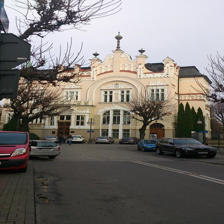

In [13]:
transformed = img.resize((224, 224))
transformed

### Prepare dataset
I created a function which prepare appropriate transfomers dataset. I will experiment on different part of dataset so it is really convient.

In [66]:
with open("data/dictionary_ids.json") as file:
    data = json.load(file)

In [65]:
df_information = pd.read_csv("data/data_informations.csv")
df_information

,filepath,label_ids,time_of_day,season
0,data/images/00_00_00.jpg,0,day,autumn
1,data/images/00_00_01.jpg,0,day,autumn
2,data/images/00_00_02.jpg,0,day,autumn
3,data/images/00_00_03.jpg,0,day,autumn
4,data/images/00_00_04.jpg,0,day,autumn
...,...,...,...,...
2995,data/images/49_05_05.jpg,49,night,spring
2996,data/images/49_05_06.jpg,49,night,spring
2997,data/images/49_05_07.jpg,49,night,spring
2998,data/images/49_05_08.jpg,49,night,spring


In [73]:
ids = data['day']
len(df_information.iloc[ids, 1].to_list())

1500

In [77]:
def create_dataset(ids: list[int], df: pd.DataFrame) -> tuple[Dataset, Dataset]:
    ids_set = set(ids)
    all_indices = set(df.index)
    test_ids = list(all_indices - ids_set)
    
    train_dataset = Dataset.from_dict({
        "image": df.iloc[ids, 0].to_list(),
        "label": df.iloc[ids, 1].to_list()
    }).cast_column("image", Image())

    test_dataset = Dataset.from_dict({
        "image": df.iloc[test_ids, 0].to_list(),
        "label": df.iloc[test_ids, 1].to_list()
    }).cast_column("image", Image())

    return train_dataset, test_dataset